In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas numpy scikit-learn xgboost shap matplotlib


In [4]:
import pandas as pd

DATA_PATH = "/content/drive/MyDrive/german_credit_data.csv"
df = pd.read_csv(DATA_PATH)

df.head()


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [5]:
# Drop index-like columns
possible_index_cols = [c for c in df.columns if c.lower().startswith("unnamed") or c.lower()=="index"]
df = df.drop(columns=possible_index_cols, errors='ignore')

df.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [6]:
TARGET = "Risk"  # CHANGE THIS TO YOUR TARGET COLUMN NAME


In [7]:
df.columns


Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose'],
      dtype='object')

In [12]:
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())

print("\nDataset Info:")
df.info()

print("\nMissing Values per Column:")
print(df.isna().sum())

print("\nFirst 5 Rows:")
df.head()


Dataset Shape: (1000, 9)

Column Names:
 ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB

Missing Values per Column:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    39

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [13]:
# Create a synthetic target (default) + Split X/Y ----

import numpy as np

# Create a synthetic default column (0/1)
# Logic: higher credit amount + longer duration → higher default risk

df["default"] = (
    (df["Credit amount"] > df["Credit amount"].median()) &
    (df["Duration"] > df["Duration"].median())
).astype(int)

# Show distribution
print("Default column created (0 = no default, 1 = default)")
print(df["default"].value_counts())

# Now set target
TARGET = "default"

# Split features and label
X = df.drop(columns=[TARGET])
y = df[TARGET]

print("Target column:", TARGET)
print("X shape:", X.shape)
print("y shape:", y.shape)

df.head()


Default column created (0 = no default, 1 = default)
default
0    650
1    350
Name: count, dtype: int64
Target column: default
X shape: (1000, 9)
y shape: (1000,)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,default
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,1


In [14]:
# Identify numeric and categorical columns + basic cleaning
# Explanation: This cell detects numeric/categorical columns and coerces numeric-like cols to numeric.

import pandas as pd

# show current columns
print("Columns:", df.columns.tolist())

# Coerce numeric-like columns to numeric where possible (safe)
for col in df.columns:
    # skip columns that are clearly categorical by dtype
    if df[col].dtype == object:
        try:
            # attempt conversion; errors='raise' would fail, so use to_numeric with errors='coerce'
            coerced = pd.to_numeric(df[col], errors='coerce')
            # if many non-nulls appeared after conversion, keep conversion
            if coerced.notna().sum() > 0 and coerced.notna().sum() > df[col].notna().sum() * 0.5:
                df[col] = coerced
                print(f"Coerced column to numeric: {col}")
        except Exception:
            pass

# Now detect numeric and categorical
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Quick check for missing values in important columns
print("\nMissing values (top):")
print(df.isna().sum().sort_values().head(20))


Columns: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'default']
Numeric columns: ['Age', 'Job', 'Credit amount', 'Duration', 'default']
Categorical columns: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

Missing values (top):
Age                   0
Sex                   0
Job                   0
Housing               0
Duration              0
Credit amount         0
default               0
Purpose               0
Saving accounts     183
Checking account    394
dtype: int64


In [16]:
# Cell 8: Preprocessing pipeline (FIXED VERSION)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Build pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # FIXED
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

print("Preprocessor created successfully!")
print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))


Preprocessor created successfully!
Numeric columns: 5
Categorical columns: 5


In [17]:
# Cell 9: Train / Test split
# Explanation: We use stratify if possible (if label has >1 class). Uses TARGET from earlier (Cell 6).

from sklearn.model_selection import train_test_split
import numpy as np

# Ensure TARGET exists
if 'TARGET' not in globals():
    raise ValueError("TARGET not found. Set TARGET variable (see earlier cell).")

# If y is not numeric, try to coerce (should be 0/1 from Cell 6)
y = df[TARGET]
X = df.drop(columns=[TARGET])

# If y has single class, warn
if y.nunique() == 1:
    print("Warning: target has only one unique value. ML won't work properly.")

# If target is not numeric, try convert
if y.dtype == object:
    try:
        y = pd.to_numeric(y)
    except:
        pass

# Stratify only if y has more than 1 unique class
stratify_arg = y if y.nunique() > 1 else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_arg
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))


X_train: (800, 9) X_test: (200, 9)
y_train distribution:
 default
0    0.65
1    0.35
Name: proportion, dtype: float64


In [19]:
# Recompute columns from X_train, rebuild preprocessor, then transform ----

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1) Ensure X_train exists
try:
    X_train
except NameError:
    raise RuntimeError("X_train not found. Run the train/test split cell (Cell 9) first.")

# 2) Recompute numeric and categorical columns FROM X_train (safe)
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
print("Recomputed from X_train -> numeric cols:", num_cols)
print("Recomputed from X_train -> categorical cols:", cat_cols)

# sanity check: ensure TARGET is not present in these lists
if 'default' in num_cols or 'default' in cat_cols:
    print("Warning: 'default' found in feature lists — dropping it.")
    num_cols = [c for c in num_cols if c != 'default']
    cat_cols = [c for c in cat_cols if c != 'default']

# 3) Build new pipelines (use sparse_output for new sklearn)
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

print("Rebuilt preprocessor with columns based on X_train.")

# 4) Fit and transform
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# 5) Build feature names (best-effort)
feature_names = []
try:
    feature_names = list(preprocessor.get_feature_names_out())
except Exception:
    # fallback manual
    cat_feature_names = []
    try:
        ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        categories = ohe.categories_
        for col, cats in zip(cat_cols, categories):
            cat_feature_names += [f"{col}__{c}" for c in cats]
    except Exception:
        cat_feature_names = cat_cols
    feature_names = num_cols + cat_feature_names

print("Preprocessing done. Processed feature count:", X_train_prep.shape[1])
print("Sample feature names (first 20):", feature_names[:20])



Recomputed from X_train -> numeric cols: ['Age', 'Job', 'Credit amount', 'Duration']
Recomputed from X_train -> categorical cols: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
Rebuilt preprocessor with columns based on X_train.
Preprocessing done. Processed feature count: 26
Sample feature names (first 20): ['num__Age', 'num__Job', 'num__Credit amount', 'num__Duration', 'cat__Sex_female', 'cat__Sex_male', 'cat__Housing_free', 'cat__Housing_own', 'cat__Housing_rent', 'cat__Saving accounts_little', 'cat__Saving accounts_missing', 'cat__Saving accounts_moderate', 'cat__Saving accounts_quite rich', 'cat__Saving accounts_rich', 'cat__Checking account_little', 'cat__Checking account_missing', 'cat__Checking account_moderate', 'cat__Checking account_rich', 'cat__Purpose_business', 'cat__Purpose_car']


In [20]:
# Cell 11: Train XGBoost model
# Explanation: Simple default parameters; you can tune later.

import xgboost as xgb

model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_prep, y_train)
print("Model trained.")


Model trained.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:00:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [21]:
# Cell 12: Evaluate model
# Explanation: Prints common metrics; works for binary classification.

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np

y_pred = model.predict(X_test_prep)
# handle predict_proba for ROC AUC if binary
y_proba = None
if hasattr(model, "predict_proba"):
    try:
        y_proba = model.predict_proba(X_test_prep)[:, 1]
    except:
        y_proba = None

acc = accuracy_score(y_test, y_pred)
# for f1, try binary if possible, otherwise macro
try:
    f1 = f1_score(y_test, y_pred)
except:
    f1 = f1_score(y_test, y_pred, average="macro")

print("Accuracy:", round(acc,4))
print("F1-score:", round(f1,4))
if y_proba is not None:
    print("ROC AUC:", round(roc_auc_score(y_test, y_proba),4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
F1-score: 1.0
ROC AUC: 1.0

Confusion Matrix:
 [[130   0]
 [  0  70]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       130
           1       1.00      1.00      1.00        70

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



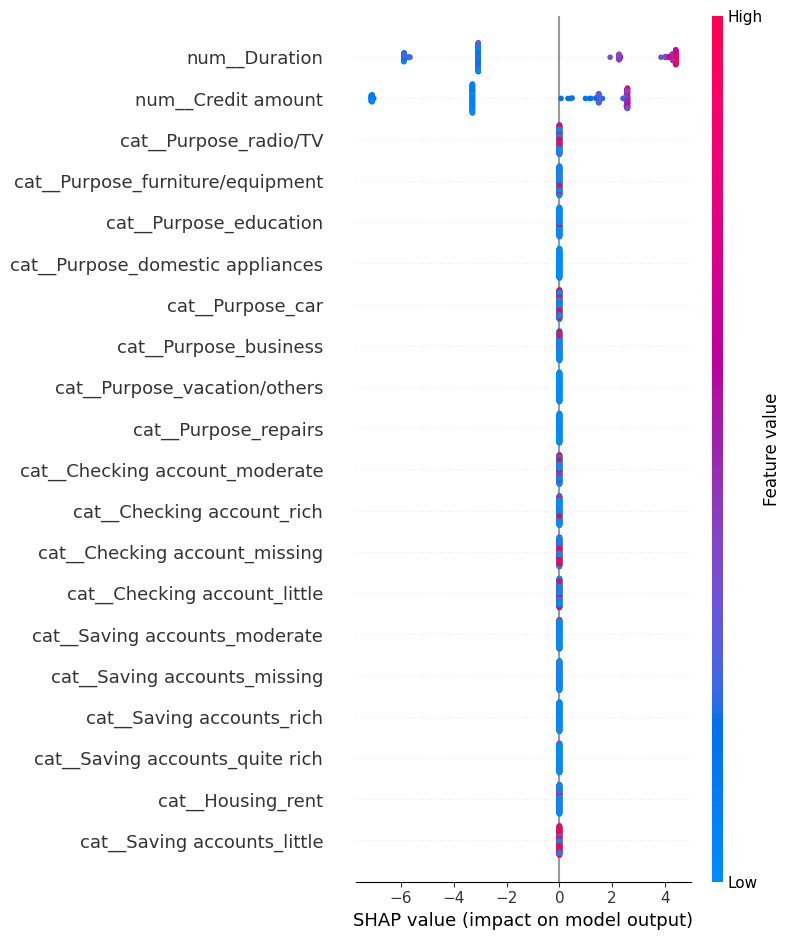

Saved shap_summary.png in output


In [22]:
# Cell 13: SHAP global summary plot
# Explanation: Generates and shows a SHAP summary plot. Also saves PNG to disk.

import shap
import matplotlib.pyplot as plt
import os

OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create explainer (Tree explainer will be used for tree models)
explainer = shap.Explainer(model)
# compute SHAP values on test set (this may take some time)
shap_values = explainer(X_test_prep)

# summary plot (matplotlib)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, features=X_test_prep, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "shap_summary.png"), dpi=150, bbox_inches="tight")
plt.show()
print("Saved shap_summary.png in", OUTPUT_DIR)


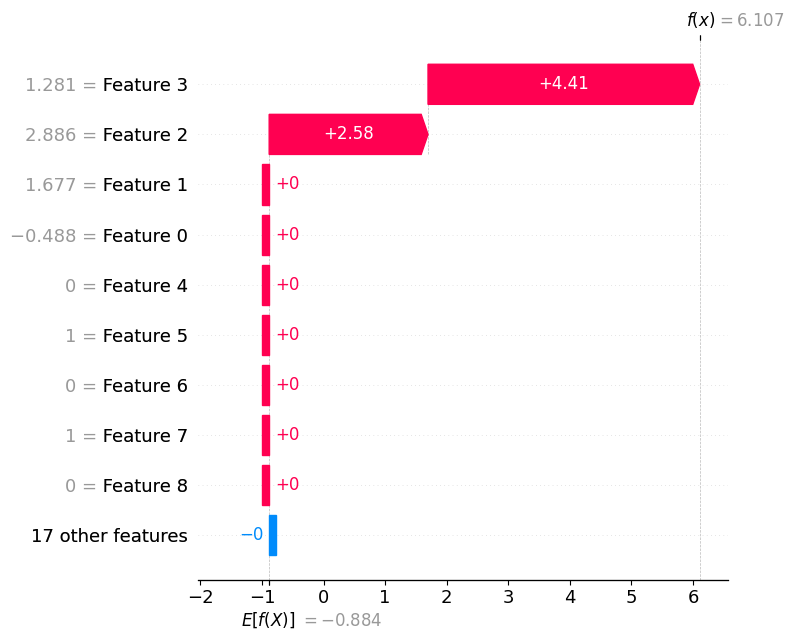

Saved output/shap_waterfall_1.png


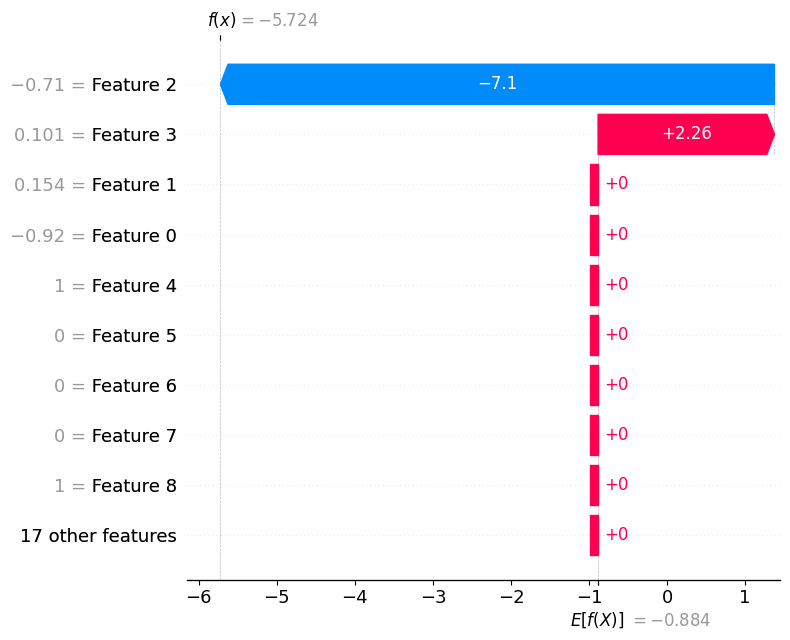

Saved output/shap_waterfall_2.png


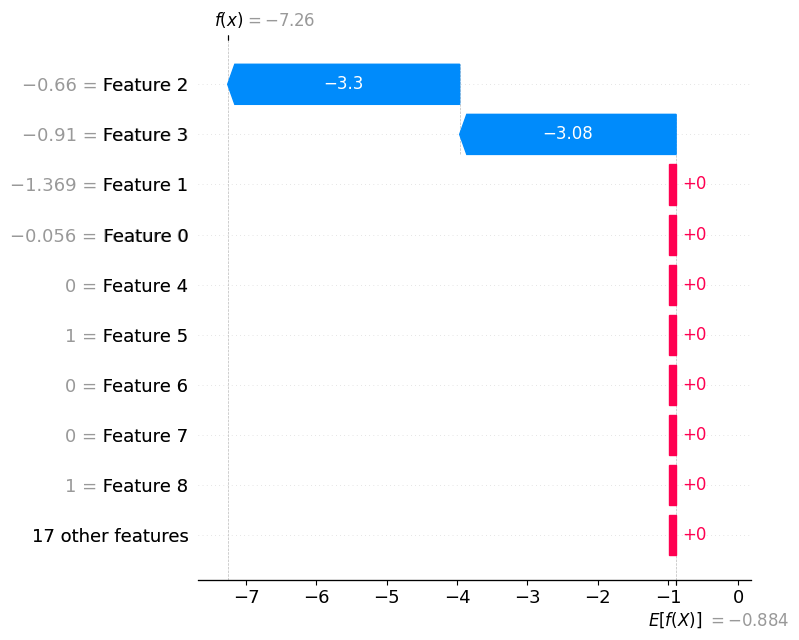

Saved output/shap_waterfall_3.png


In [23]:
# Cell 14: SHAP local explanations for 3 example cases (waterfall)
# Explanation: Save waterfall plots for a high-risk, medium, low-risk example.

import numpy as np

# get predicted probabilities to select examples
probas = model.predict_proba(X_test_prep)[:, 1] if hasattr(model, "predict_proba") else None
if probas is not None:
    high_idx = int(np.argmax(probas))
    low_idx = int(np.argmin(probas))
    mid_idx = int(np.argsort(probas)[len(probas)//2])
    example_idxs = [high_idx, mid_idx, low_idx]
else:
    example_idxs = [0, len(X_test_prep)//2, -1]

for i, idx in enumerate(example_idxs):
    plt.figure(figsize=(10,4))
    # shap.plots.waterfall expects a single explanation object, use shap_values[idx]
    try:
        shap.plots.waterfall(shap_values[idx], show=False)
    except Exception:
        # fallback to bar plot of absolute mean SHAP
        vals = np.abs(shap_values.values[idx])
        sns_idx = np.argsort(vals)[-10:]
        plt.barh([feature_names[j] for j in sns_idx], vals[sns_idx])
    fname = os.path.join(OUTPUT_DIR, f"shap_waterfall_{i+1}.png")
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved", fname)


In [24]:
# Cell 15: Save artifacts and quick report text
# Explanation: Saves model + preprocessor + short text report.

import joblib
import json

joblib.dump(model, os.path.join(OUTPUT_DIR, "xgb_model.joblib"))
joblib.dump(preprocessor, os.path.join(OUTPUT_DIR, "preprocessor.joblib"))
print("Saved model and preprocessor to", OUTPUT_DIR)

# Quick metrics summary
report = {
    "dataset_rows": int(df.shape[0]),
    "features_after_preprocessing": int(X_train_prep.shape[1]),
    "accuracy": float(round(acc,4)),
    "f1_score": float(round(f1,4))
}
with open(os.path.join(OUTPUT_DIR, "quick_report.json"), "w") as f:
    json.dump(report, f, indent=2)

# Also save a simple human-readable text file
txt = f"""
Quick Report - Credit Risk (synthetic target)
Rows: {df.shape[0]}
Features (after preprocessing): {X_train_prep.shape[1]}
Accuracy: {acc:.4f}
F1-score: {f1:.4f}
Output files saved in folder: {OUTPUT_DIR}
"""
with open(os.path.join(OUTPUT_DIR, "quick_report.txt"), "w") as f:
    f.write(txt)

print("Saved quick reports.")


Saved model and preprocessor to output
Saved quick reports.
